### Objetivo:

Criar e testar modelos de estatística tradicional com intuito de prever e identificar as variáveis que mais influenciam para que estudante vá fumar cigarro na adolescência


### Etapas:

1) Carregando tabelas e importando bibliotecas

2) Modelagem estatística, definição de métrica a ser avaliada e importância das varíaveis
- 2.1) Regressão logística 
- 2.2) Árvore de decisão
- 2.3) Gaussian Naive de Bayes

### 1) Carregando tabelas e importando bibliotecas

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,recall_score,classification_report,roc_curve, auc
from sklearn.inspection import permutation_importance
!pip install shap
import shap

Requirement already satisfied: shap in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (0.37.0)
Requirement already satisfied: scikit-learn in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from shap) (0.22.1)
Requirement already satisfied: numpy in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from shap) (1.18.1)
Requirement already satisfied: numba in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from shap) (0.51.2)
Requirement already satisfied: tqdm>4.25.0 in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from shap) (4.42.1)
Requirement already satisfied: scipy in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from shap) (1.4.1)
Requirement already satisfied: slicer==0.0.3 in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from shap) (0.0.3)
Requirement already satisfied: pandas in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from shap) (1.0.1)
Requirement already satisfied: joblib>=0.11 in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from scikit-learn->shap) (0.14.1)
Requirement already satisfied: llvmlite<0.35,>=0.34.0.dev0 in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from numba->shap) (0.34.0)
Requirement already satisfied: setuptools in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from numba->shap) (45.2.0.post20200210)
Requirement already satisfied: python-dateutil>=2.6.1 in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pandas->shap) (2.8.1)
Requirement already satisfied: pytz>=2017.2 in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from pandas->shap) (2019.3)
Requirement already satisfied: six>=1.5 in /databricks/conda/envs/databricks-ml/lib/python3.7/site-packages (from python-dateutil>=2.6.1->pandas->shap) (1.14.0)

In [0]:
abt_treino = spark.sql("select * from abt_treino_fs")
abt_teste = spark.sql("select * from abt_teste_fs")

abt_treino = abt_treino.toPandas()
abt_teste = abt_teste.toPandas()

y_train = abt_treino[['ja_fumou']]
y_test = abt_teste[['ja_fumou']]
x_train= abt_treino.drop(columns=['ja_fumou'],axis=1)
x_test= abt_teste.drop(columns=['ja_fumou'],axis=1)

### 2) Modelagem estatística, definição de métrica a ser avaliada e importância das varíaveis

Nessa fase foi definido que a métrica a ser avaliada será o recall, pois é mais relevante identificar o quanto o modelo acertou dos alunos que responderam que já tiveram uma experiência com cigarros

- Classification report
- Matriz de confusão
- Importância das variáveis

### 2.1) Regressão Logística

In [0]:
lr = LogisticRegression()
lr.fit(x_train,y_train['ja_fumou'])

y_prob = lr.predict_proba(x_test)[:,1] 
y_pred = np.where(y_prob > 0.5, 1, 0)

print("acc:",accuracy_score(y_test['ja_fumou'],y_pred))
print("recall:",recall_score(y_test['ja_fumou'],y_pred))

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
acc: 0.8588922996538436
recall: 0.4243955250811981

In [0]:
dict = classification_report(y_test['ja_fumou'],y_pred, output_dict=True)
pd.DataFrame(dict)

Out[21]:

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.882457,0.675280,0.858892,0.778868,0.844962
recall,0.954904,0.424396,0.858892,0.689650,0.858892
f1-score,0.917252,0.521219,0.858892,0.719236,0.845578
support,25080.000000,5542.000000,0.858892,30622.000000,30622.000000


Out[22]:

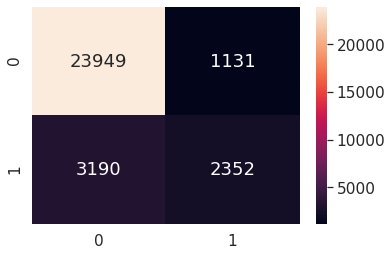

<matplotlib.axes._subplots.AxesSubplot at 0x7f18a4455290>

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test['ja_fumou'],y_pred)

sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 18}, fmt='g')

In [0]:
coef = pd.DataFrame(lr.coef_)
coef_lr = coef.transpose()
tab = pd.DataFrame(abt_treino.columns)
coef_lr['columns'] = tab[0]
coef_lr.columns =['coeficientes','variáveis']
coef_lr.sort_values(by='coeficientes',ascending=False).head(15)   


Out[23]:

,coeficientes,variáveis
0,1.020678,qtd_embriaguez_na_vida3a5vezesnavida
6,0.870699,ja_usou_droga
7,0.870699,ja_bebeu
2,0.786129,qtd_embriaguez_na_vida10oumaisvezesnavida
8,0.751658,doses_ultimo_mes30dias
9,0.747600,Ja_Teve_Relacao_Sexual
1,0.639671,qtd_embriaguez_na_vida1ou2vezesnavida
4,0.577861,qtd_amigos_que_drogasAmaioria
10,0.444954,Como_Conseguiu_Bebida_ultimo_mesConseguicommeu...
17,0.411838,qtd_dias_bebida_ultimo_mes10a19diasnosultimos3...


In [0]:
print("Intercept:",lr.intercept_)


Intercept: [-2.92880516]

### 2.2) Árvore de decisão

In [0]:
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(x_train,y_train['ja_fumou'])

print("acc:",accuracy_score(y_test['ja_fumou'],dt.predict(x_test)))
print("recall:",recall_score(y_test['ja_fumou'],dt.predict(x_test)))

acc: 0.8325060414081379
recall: 0.5102850956333453

In [0]:
dict = classification_report(y_test['ja_fumou'],dt.predict(x_test) , output_dict=True)
pd.DataFrame(dict)

Out[10]:

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.893061,0.539386,0.832506,0.716224,0.829053
recall,0.903708,0.510285,0.832506,0.706997,0.832506
f1-score,0.898353,0.524432,0.832506,0.711393,0.830681
support,25080.000000,5542.000000,0.832506,30622.000000,30622.000000


Out[11]:

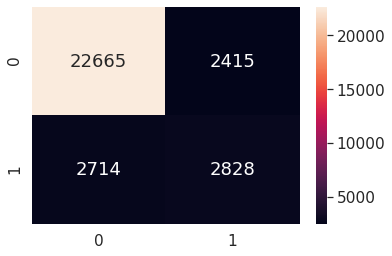

<matplotlib.axes._subplots.AxesSubplot at 0x7f18ad28fc50>

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test['ja_fumou'],dt.predict(x_test))

sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 18}, fmt='g')

In [0]:

importancia = pd.DataFrame(OrderedDict({'Variaveis':x_train.columns,
                                        'Importancia':dt.feature_importances_}))
importancia = importancia.sort_values(by='Importancia', ascending=False)
importancia.head(15)

Out[12]:

,Variaveis,Importancia
6,ja_usou_droga,0.559162
9,Ja_Teve_Relacao_Sexual,0.250906
22,qtd_amigos_que_drogasNenhum,0.118495
8,doses_ultimo_mes30dias,0.034811
4,qtd_amigos_que_drogasAmaioria,0.023111
19,qtd_dias_Pais_Verificaram_Deveres_ultimo_mesNunca,0.006259
1,qtd_embriaguez_na_vida1ou2vezesnavida,0.005463
20,qtd_brigas_por_bebidaNenhumaveznavida0vez,0.001793
26,ofendeu_Pessoas_ultimo_mes,0.000000
23,qtd_amigos_que_bebemTodos,0.000000


### 2.3) Gaussian Naive de Bayes

In [0]:
gnb = GaussianNB()
gnb.fit(x_train,y_train['ja_fumou'])

print("acc:",accuracy_score(y_test['ja_fumou'],gnb.predict(x_test)))
print("recall:",recall_score(y_test['ja_fumou'],gnb.predict(x_test)))


acc: 0.8239174449742016
recall: 0.6163839769036449

In [0]:
dict = classification_report(y_test['ja_fumou'],gnb.predict(x_test) , output_dict=True)
pd.DataFrame(dict)

Out[15]:

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.911195,0.511224,0.823917,0.711209,0.838808
recall,0.869777,0.616384,0.823917,0.743080,0.823917
f1-score,0.890004,0.558901,0.823917,0.724452,0.830081
support,25080.000000,5542.000000,0.823917,30622.000000,30622.000000


In [0]:
imps = permutation_importance(gnb, x_test, gnb.predict(x_test))
tab_result = pd.DataFrame(imps.importances_mean)
tab = pd.DataFrame(abt_treino.columns)
tab_result['columns'] = tab[0]
tab_result.columns =['permutation_importance','variáveis']
tab_result.sort_values(by='permutation_importance',ascending=False).head(15)                           

Out[16]:

,permutation_importance,variáveis
0,0.026327,qtd_embriaguez_na_vida3a5vezesnavida
4,0.022912,qtd_amigos_que_drogasAmaioria
11,0.021788,Como_Conseguiu_Bebida_ultimo_mesCompreinomerca...
10,0.021475,Como_Conseguiu_Bebida_ultimo_mesConseguicommeu...
2,0.020051,qtd_embriaguez_na_vida10oumaisvezesnavida
8,0.019848,doses_ultimo_mes30dias
14,0.018928,qtd_dias_bebida_ultimo_mes6a9diasnosultimos30dias
6,0.018594,ja_usou_droga
7,0.018594,ja_bebeu
15,0.018229,qtd_dias_bebida_ultimo_mes3a5diasnosultimos30dias


Out[17]:

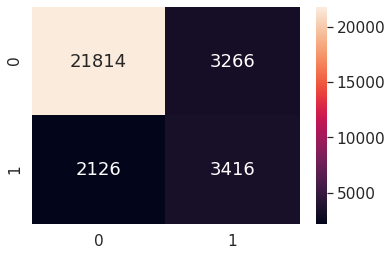

<matplotlib.axes._subplots.AxesSubplot at 0x7f18a4529650>

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test['ja_fumou'],gnb.predict(x_test))

sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 18}, fmt='g')

In [0]:
comparando = pd.DataFrame({'Naive de Bayes':recall_score(y_test['ja_fumou'],gnb.predict(x_test)),
                            'Regressão Logística':recall_score(y_test['ja_fumou'],lr.predict(x_test)),
                            'Árvore de Decisao':recall_score(y_test['ja_fumou'],dt.predict(x_test))},index=[0])
comparando = comparando.transpose()
comparando

Out[27]:

,0
Naive de Bayes,0.616384
Regressão Logística,0.424396
Árvore de Decisao,0.510285


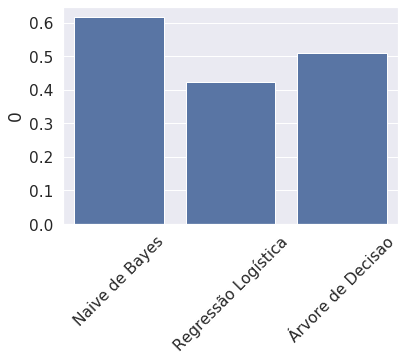

In [0]:
sns.barplot(x=comparando.index,y=0, data=comparando, color="b")
plt.xticks(rotation=45)
plt.show()